# USE "TPU v5e-1" to handle with the full dataset


# Update Kaggle lib and put credentials

In [1]:
!pip install --quiet kaggle --upgrade

To use the Kaggle API, sign up for a Kaggle account at https://www.kaggle.com. <br> Then go to Settings (https://www.kaggle.com/settings) and select 'Create API Token'.

# Download data

In [2]:
import os
os.environ['KAGGLE_USERNAME'] = 'alexeyorlovmipt'
os.environ['KAGGLE_API_TOKEN'] = 'KGAT_508653e2b4ad408d1f7c8fbd0674ecd7'

In [3]:
# !kaggle competitions download -c mipt-gnn-2025

In [4]:
# !unzip mipt-gnn-2025.zip

In [5]:
import torch
import torch_geometric
print(torch.cuda.is_available())

True


In [6]:
import numpy as np
import pandas as pd
import sys
import os
import pandas as pd
import numpy as np
import tqdm
import time
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import warnings
warnings.filterwarnings('ignore')

# Read raw

In [7]:
# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [8]:
dirname = 'mipt-gnn-2025/'

In [ ]:
# %%time
df_edges = pd.read_parquet(os.path.join(dirname,'df_edges.parquet'))
df_nodes = pd.read_parquet(os.path.join(dirname,'df_nodes.parquet'))

CPU times: total: 17 s
Wall time: 2.01 s


In [10]:
df_nodes.head(2)

,node_feature_1,node_feature_2,node_feature_3,node_feature_4,node_feature_5,node_feature_6,node_feature_7,node_feature_8,node_feature_9,node_feature_10,...,node_feature_237,node_feature_238,node_feature_239,node_feature_240,node_feature_241,node_feature_242,node_feature_243,node_feature_244,node_feature_245,index
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,0.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,1.0,...,1.753344,2.027835,0.0,0.0,0.0,0.0,0.0,0.429199,0.0,1


In [11]:
node_group_col = 'node_feature_1'
del df_nodes['index']

In [12]:
a = df_nodes.isnull()#.sum(axis=0)

b = a[df_nodes[node_group_col]==0].sum(axis=0)
features_group0 = b[b==0].index.tolist()
features_group0.remove(node_group_col)

b = a[df_nodes[node_group_col]==1].sum(axis=0)
features_group1 = b[b==0].index.tolist()
features_group1.remove(node_group_col)

del a

In [13]:
print("Число фичей для группы вершин 0:",len(features_group0))
print("Число фичей для группы вершин 1:",len(features_group1))

Число фичей для группы вершин 0: 134
Число фичей для группы вершин 1: 162


In [14]:
# Найдем индексы этих фичей
cols = df_nodes.columns.tolist()
features_idx_group0 = [cols.index(c) for c in features_group0]
features_idx_group1 = [cols.index(c) for c in features_group1]
df_edges.head(2)

,edge_feature_1,edge_feature_2,edge_feature_3,edge_feature_5,edge_feature_7,edge_feature_9,edge_feature_11,edge_feature_12,edge_feature_13,edge_feature_14,...,edge_feature_41,edge_feature_42,edge_feature_43,edge_feature_44,edge_feature_45,edge_feature_46,edge_feature_47,edge_feature_48,index1,index2
0,1.0,1.0,-1.489233,-2.149860,0.874358,-2.07540,-0.81038,1.519856,0.744896,-0.484251,...,0.133585,0.000000,0.000000,0.000000,0.153324,0.000000,0.0,0.0,14995,0
1,1.0,1.0,0.756959,0.831242,-0.422108,0.88719,-0.81038,0.233813,0.744896,0.829714,...,0.506228,0.299537,0.928534,0.909701,0.969412,0.772556,0.0,0.0,14996,0


In [15]:
x = torch.FloatTensor(df_nodes.values)
edge_index = torch.LongTensor(df_edges[['index1','index2']].values).T

del df_edges['index1']
del df_edges['index2']

edge_attr = torch.FloatTensor(df_edges.values)
from torch_geometric.data import Data
del df_edges

In [16]:
import gc
gc.collect()

0

### Таргет

In [17]:
df_train = pd.read_csv(os.path.join(dirname,'train.csv'))
df_test = pd.read_csv(os.path.join(dirname,'test.csv'))
# 4 бинарных таргета
# доли 1 в каждом тарегте, число 1, размер выборки по таргету
df_train.groupby('label_type').y.agg(['mean','sum','count'])

,mean,sum,count
label_type,,,
label_3,0.247525,75,303
label_4,0.171748,338,1968
label_5,0.208788,708,3391
label_6,0.088658,401,4523


In [18]:
# размер выборки по таргету для test
df_test.label_type.value_counts()

label_type
label_6    2229
label_5    1671
label_4     969
label_3     149
Name: count, dtype: int64

In [19]:
df_y = df_train.pivot(columns='label_type',index='index',values='y')
df_y.head()

label_type,label_3,label_4,label_5,label_6
index,,,,
2,NaN,NaN,0.0,NaN
3,NaN,NaN,0.0,NaN
4,NaN,0.0,NaN,NaN
5,NaN,0.0,NaN,NaN
9,NaN,NaN,NaN,0.0


In [20]:
df_y_ = pd.DataFrame(np.arange(len(x)) , columns=['index'])
df_y = df_y_.merge(df_y.reset_index(), on='index',how='left').set_index('index')
df_y.head()

,label_3,label_4,label_5,label_6
index,,,,
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,0.0,NaN
3,NaN,NaN,0.0,NaN
4,NaN,0.0,NaN,NaN


In [21]:
df_y['has_target'] = df_y.notnull().sum(axis=1) > 0
df_y = df_y.fillna(-100)
df_y.head(1)

,label_3,label_4,label_5,label_6,has_target
index,,,,,
0,-100.0,-100.0,-100.0,-100.0,False


In [22]:
node_type = torch.ShortTensor(df_nodes[node_group_col].values)

### Data

In [23]:
# 4 таргета
label_3 = torch.LongTensor(df_y.label_3.values)
label_4 = torch.LongTensor(df_y.label_4.values)
label_5 = torch.LongTensor(df_y.label_5.values)
label_6 = torch.LongTensor(df_y.label_6.values)

#
has_target = torch.BoolTensor(df_y.has_target.values)

In [24]:
# cобираем ключевой объект data
data = Data(x=x, # node features
            edge_index=edge_index, # edges
            edge_attr=edge_attr, # edge attributes
            label_3=label_3,
            label_4=label_4,
            label_5=label_5,
            label_6=label_6,
            has_target=has_target,# whether node has target
            node_type=node_type, # 0 or 1st type of node
            index = torch.arange(len(x))# unique identifier of node
           )

In [25]:
print('===================================')

print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of edges: {data.edge_index.shape[1]}')
print(f'Number of features: {data.x.shape[1]}')

if data.edge_attr is not None:
    print(f'Number of edge attributes: {data.edge_attr.shape[1]}')


print(f'Number of nodes with target: {int(data.has_target.sum())}')
print('===================================')

Number of nodes: 3345036
Number of edges: 3907086
Number of features: 245
Number of edge attributes: 44
Number of nodes with target: 10046


### Локальная валидация

In [26]:
from sklearn.model_selection import train_test_split
stratify = df_y[df_y['has_target']].drop('has_target',axis=1).max(axis=1)
train_index, valid_index = train_test_split(torch.nonzero(data.has_target)[:,0],
                                            test_size=0.2,
                                            shuffle=True,
                                            stratify=stratify,
                                            random_state=402)
test_index = df_test['index'].unique()
len(train_index), len(valid_index), len(test_index)

(8036, 2010, 4949)

In [27]:
from torch_geometric.loader import NeighborLoader
batch_size = 200

loader_train = NeighborLoader(
    data,
    num_neighbors=[-1, -1],
    batch_size=batch_size,
    shuffle=False,
    input_nodes=train_index,
)

loader_valid = NeighborLoader(
    data,
    num_neighbors=[-1, -1],
    batch_size=batch_size,
    shuffle=False,
    input_nodes=valid_index,
)


loader_test = NeighborLoader(
    data,
    num_neighbors=[-1, -1],
    batch_size=batch_size,
    shuffle=False,
    input_nodes=test_index,
)

# предрасчитываем разбиение графа на батчи
loader_train = [c for c in tqdm.tqdm(loader_train)]
loader_valid = [c for c in tqdm.tqdm(loader_valid)]
loader_test = [c for c in tqdm.tqdm(loader_test)]

100%|██████████| 25/25 [00:00<00:00, 52.45it/s]


### Модель

In [28]:
from torch.nn import Linear, ReLU, Sequential, Identity, Dropout, PReLU, Tanh, ELU, LeakyReLU, Sigmoid, GELU
from torch_geometric.nn import GraphConv, SAGEConv

In [29]:
class GeneralGNN(torch.nn.Module):
    def __init__(self,
                 Act = ReLU,
                 ConvClass = GraphConv,
                 hidden_size1 = 256,
                 conv1_aggrs = {'mean':128, 'max':64, 'add':32},
                 conv2_aggrs = {'mean': 64, 'max':16, 'add':8},
                 dropout_rate = 0.25,
                 target_names = ['label_3','label_4','label_5','label_6'],
                 features_idx_group0 = features_idx_group0,
                 features_idx_group1 = features_idx_group1,
                ):
        super(GeneralGNN, self).__init__()
        torch.manual_seed(420)

        self.hidden_size1 = hidden_size1
        self.target_names = target_names
        self.features_idx_group0 = features_idx_group0
        self.features_idx_group1 = features_idx_group1


        # preprocces node featrues, reduce to a common dimension
        self.lin_preproc = torch.nn.ModuleList(
            modules = [
                Linear(len(features_idx_group0), hidden_size1),
                Linear(len(features_idx_group1), hidden_size1)
            ]
        )
        self.activation = Act()
        self.dropout = Dropout(dropout_rate)


        # 1-level convolution with different aggregate functions
        input_size = hidden_size1

        self.conv1 = torch.nn.ModuleDict()
        for aggr, output_size in conv1_aggrs.items():
            self.conv1[aggr] = ConvClass(input_size, output_size, aggr)

        self.conv1_activation = Act()
        self.conv1_dropout = Dropout(dropout_rate)


        # 2-level convolution with different aggregate functions
        input_size = sum(conv1_aggrs.values())

        self.conv2 = torch.nn.ModuleDict()
        for aggr, output_size in conv2_aggrs.items():
            self.conv2[aggr] = ConvClass(input_size, output_size, aggr)

        self.conv2_activation = Act()
        self.conv2_dropout = Dropout(dropout_rate)
        # MAKE PREDICTION FOR EACH TASK
        input_size = sum(conv2_aggrs.values())
        self.lin_out = torch.nn.ModuleDict()
        for name in self.target_names:
            self.lin_out[name] = Linear(input_size, 2)


    def forward(self, data):
        x = data.x
        edge_index = data.edge_index
        node_type = data.node_type

        # preprocces node featrues, reduce to a common dimension
        x_out = torch.zeros(len(x), self.hidden_size1, device=x.device)

        x_out[node_type==0] = self.lin_preproc[0](x[node_type==0][:,self.features_idx_group0])
        x_out[node_type==1] = self.lin_preproc[1](x[node_type==1][:,self.features_idx_group1])

        x = self.dropout(self.activation(x_out))

        # concatencate outputs of 1-level convolution with different aggregate functions
        x_out = []
        for conv in self.conv1.values():
            x_out.append(conv(x, edge_index))
        x = torch.cat(x_out, dim=1)
        x = self.conv1_dropout(self.conv1_activation(x))

        # concatencate outputs of 2-level convolution with different aggregate functions
        x_out = []
        for conv in self.conv2.values():
            x_out.append(conv(x, edge_index))
        x = torch.cat(x_out, dim=1)
        x = self.conv2_dropout(self.conv2_activation(x))

        # модель возвращает dict,
        # где ключ - это имя 1 из 4 таргетов,
        # значение - логиты 2х классов (0 и 1) по каждой вершине
        outs = {name: self.lin_out[name](x) for name in self.target_names}

        return outs

In [30]:
model = GeneralGNN()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

GeneralGNN(
  (lin_preproc): ModuleList(
    (0): Linear(in_features=134, out_features=256, bias=True)
    (1): Linear(in_features=162, out_features=256, bias=True)
  )
  (activation): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (conv1): ModuleDict(
    (mean): GraphConv(256, 128)
    (max): GraphConv(256, 64)
    (add): GraphConv(256, 32)
  )
  (conv1_activation): ReLU()
  (conv1_dropout): Dropout(p=0.25, inplace=False)
  (conv2): ModuleDict(
    (mean): GraphConv(224, 64)
    (max): GraphConv(224, 16)
    (add): GraphConv(224, 8)
  )
  (conv2_activation): ReLU()
  (conv2_dropout): Dropout(p=0.25, inplace=False)
  (lin_out): ModuleDict(
    (label_3): Linear(in_features=88, out_features=2, bias=True)
    (label_4): Linear(in_features=88, out_features=2, bias=True)
    (label_5): Linear(in_features=88, out_features=2, bias=True)
    (label_6): Linear(in_features=88, out_features=2, bias=True)
  )
)

In [31]:
def train_epoch(model, loader, device, optimizer, scheduler, tqdm_disable=True):
    """
    учим модель одну эпоху
    """
    start_time = time.time()

    model.train()
    total_loss = 0

    for sampled_data in tqdm.tqdm(loader, leave=False, disable=tqdm_disable):
        sampled_data = sampled_data.clone().to(device)
        sampled_data.has_target[sampled_data.batch_size:] = False

        optimizer.zero_grad()
        outs = model(sampled_data)
        loss = get_train_loss(sampled_data, outs)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()

        total_loss += loss.detach().item() / len(loader)

    scheduler.step()

    calc_time = time.time() - start_time
    return total_loss, calc_time

In [32]:
# считаем лосс как сумму лоссов по каждому таргету
def get_train_loss(sampled_data, outs):
    ys = {name: getattr(sampled_data,name)[:sampled_data.batch_size] for name in target_names}
    outs = {name: outs[name][:sampled_data.batch_size] for name in target_names}
    loss = 0
    for name in target_names:
        y = ys[name]
        out = outs[name]
        l = criterion(out,y)
        if not torch.isnan(l):
            loss +=l
    return loss/batch_size

In [33]:
def eval_model(model, loader, device, tqdm_disable=True):
    """
    get prediction


    """
    start_time = time.time()
    softmax = torch.nn.Softmax(dim=1)

    dfs = []

    model.eval()
    with torch.no_grad():

        for sampled_data in tqdm.tqdm(loader, leave=False, disable=tqdm_disable):
            sampled_data = sampled_data.clone().to(device)
            outs = model(sampled_data)
            outs = {name: softmax(
                                outs[name][:sampled_data.batch_size].detach()
                            )[:,1].cpu().numpy() for name in target_names
                   }
            outs['index'] = sampled_data.index[:sampled_data.batch_size].cpu().numpy()
            dfs.append(pd.DataFrame(outs))

    result = pd.concat(dfs,axis=0)

    df_score = pd.melt(result, id_vars=['index'], value_vars=target_names).rename(
    columns={'variable':'label_type','value':'score'})
    return df_score

In [34]:
from sklearn.metrics import roc_auc_score
def cacl_auc(df_score, df_truth):
    df = df_truth.merge(df_score, on=['index','label_type'])
    return roc_auc_score(df.y, df.score) #, df.shape[0]

In [35]:
target_names = ['label_3','label_4','label_5','label_6']

In [36]:
# там где таргет -100 лосс не считаем
criterion = torch.nn.CrossEntropyLoss(reduction='sum', ignore_index=-100, label_smoothing = 0.001)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-5)
scheduler = torch.optim.lr_scheduler.MultiStepLR(
      optimizer = optimizer,
      milestones = [10, 20, 40],
      gamma = 0.1)

### Train

In [37]:
train_auc_values = []
valid_auc_values = []

# 1.5 min per epoch
for epoch in range(10):
    total_loss, calc_time = train_epoch(model, loader_train, device, optimizer, scheduler, tqdm_disable=False)

    df_score = eval_model(model, loader_train, device, tqdm_disable=True)
    train_auc = cacl_auc(df_score, df_train)

    df_score = eval_model(model, loader_valid, device, tqdm_disable=True)
    valid_auc = cacl_auc(df_score, df_train)

    print(f'Epcoh:{epoch:03d} TrainLoss : {total_loss:.3f}, Train AUC : {train_auc:.3f}, VALID AUC : {valid_auc:.3f}',
          file=sys.stderr)
    train_auc_values.append(train_auc)
    valid_auc_values.append(valid_auc)

Epcoh:000 TrainLoss : 1.023, Train AUC : 0.719, VALID AUC : 0.741
Epcoh:001 TrainLoss : 0.393, Train AUC : 0.751, VALID AUC : 0.755
Epcoh:002 TrainLoss : 0.385, Train AUC : 0.748, VALID AUC : 0.743
Epcoh:003 TrainLoss : 0.379, Train AUC : 0.777, VALID AUC : 0.770
Epcoh:004 TrainLoss : 0.374, Train AUC : 0.783, VALID AUC : 0.760
Epcoh:005 TrainLoss : 0.376, Train AUC : 0.772, VALID AUC : 0.754
Epcoh:006 TrainLoss : 0.374, Train AUC : 0.789, VALID AUC : 0.755
Epcoh:007 TrainLoss : 0.362, Train AUC : 0.808, VALID AUC : 0.758
Epcoh:008 TrainLoss : 0.361, Train AUC : 0.812, VALID AUC : 0.766
Epcoh:009 TrainLoss : 0.362, Train AUC : 0.815, VALID AUC : 0.760


In [38]:
df_score = eval_model(model, loader_test, device, tqdm_disable=True)

df_submission = df_score.merge(df_test, on=['index','label_type'])

df_submission[['task_id','score']].to_csv('submission.csv',index=False, header=True)

# Plot metric

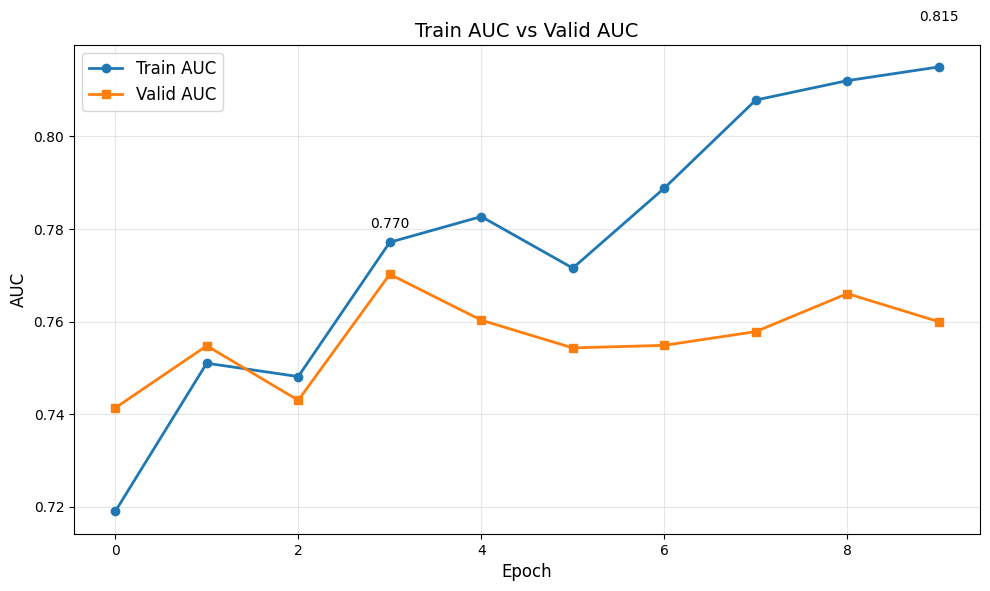

Лучший Train AUC: 0.815 на эпохе 9
Лучший Valid AUC: 0.770 на эпохе 3


In [39]:
import matplotlib.pyplot as plt

# Построение графика
plt.figure(figsize=(10, 6))
epochs = range(len(train_auc_values))

plt.plot(epochs, train_auc_values, label='Train AUC', marker='o', linewidth=2)
plt.plot(epochs, valid_auc_values, label='Valid AUC', marker='s', linewidth=2)

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('AUC', fontsize=12)
plt.title('Train AUC vs Valid AUC', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Добавим аннотации для лучших значений
max_train_idx = train_auc_values.index(max(train_auc_values))
max_valid_idx = valid_auc_values.index(max(valid_auc_values))

plt.annotate(f'{train_auc_values[max_train_idx]:.3f}', 
             xy=(max_train_idx, train_auc_values[max_train_idx]),
             xytext=(max_train_idx, train_auc_values[max_train_idx] + 0.01),
             ha='center', fontsize=10)

plt.annotate(f'{valid_auc_values[max_valid_idx]:.3f}', 
             xy=(max_valid_idx, valid_auc_values[max_valid_idx]),
             xytext=(max_valid_idx, valid_auc_values[max_valid_idx] + 0.01),
             ha='center', fontsize=10)

plt.tight_layout()
plt.show()

# Также выведем лучшие значения
print(f"Лучший Train AUC: {max(train_auc_values):.3f} на эпохе {max_train_idx}")
print(f"Лучший Valid AUC: {max(valid_auc_values):.3f} на эпохе {max_valid_idx}")

# Submit

In [40]:
# !kaggle competitions submit mipt-gnn-2025 -f submission.csv -m "baseline submission"